In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import LSTM,GRU,Dense,Input,Concatenate
from tensorflow.keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
from keras import backend
 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [3]:
df = pd.read_csv('./NewDataset/New_dataset_features.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df.head()

,shop_id,item_category_id,average_price_per_shop,average_price_per_category,average_items_per_shop,average_items_per_category,month_0,month_1,month_2,month_3,...,month_24,month_25,month_26,month_27,month_28,month_29,month_30,month_31,month_32,month_33
0,0,2,563.44,2261.71,1.19,1.06,53.0,52.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,3,563.44,2105.68,1.19,1.18,28.0,24.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,4,563.44,554.70,1.19,1.04,16.0,22.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,5,563.44,865.31,1.19,1.03,28.0,35.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,6,563.44,1892.90,1.19,1.11,65.0,79.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
def split_rnn(df, look_back):
    x1_ = df[['shop_id','item_category_id','average_price_per_category','average_price_per_shop','average_items_per_shop','average_items_per_category']]
    x1 = pd.DataFrame()
    x2 = pd.DataFrame()
    y = pd.DataFrame()
    for i in range(32-look_back):
        x2_aux = pd.DataFrame()
        for k in range(look_back):
            x2_ = df[['month_'+str(i+k)]]
            x2_ = x2_.rename(columns={'month_'+str(i+k):'month_'+str(k)})
            x2_aux = pd.concat([x2_aux,x2_],axis=1)
        y_ = df[['month_'+str(i+look_back)]]
        y_ = y_.rename(columns={'month_'+str(i+look_back):'month'})
        x1 = pd.concat([x1,x1_],axis=0)
        x2 = pd.concat([x2,x2_aux],axis=0)
        y = pd.concat([y,y_],axis=0)
    x1_test = pd.DataFrame()
    x2_test = pd.DataFrame()
    y_test = pd.DataFrame()
    for i in range(32-look_back,34-look_back,1):
        print(i)
        x2_aux = pd.DataFrame()
        for k in range(look_back):
            x2_t = df[['month_'+str(i+k)]]
            x2_t = x2_.rename(columns={'month_'+str(i+k):'month_'+str(k)})
            x2_aux = pd.concat([x2_aux,x2_],axis=1)
        y_t = df[['month_'+str(i+look_back)]]
        y_t = y_t.rename(columns={'month_'+str(i+look_back):'month'})
        x1_test = pd.concat([x1_test,x1_],axis=0)
        x2_test = pd.concat([x2_test,x2_aux],axis=0)
        y_test = pd.concat([y_test,y_t],axis=0)
    train = (np.array(x1),np.array(x2).reshape(-1,look_back,1),np.array(y))
    test = (np.array(x1_test),np.array(x2_test).reshape(-1,look_back,1),np.array(y_test))
    return {'train':train,'test':test}

In [5]:
def calculate_cost_of_sales(cost,expense,quantity,initial_inventory=0):
    '''
    cost_per_item = (cost_per_item+expense_per_item)*(quanrity_per_item+initial_inventory_per_item)
    '''
    return float((cost+expense)*(quantity+initial_inventory))

def calculate_expense(expense,quantity,initial_inventory=0):
    '''
    experse_per_item = expense_per_item*(quantity_per_item + initial_invrntory_per_item)
    '''
    return float(expense*(quantity+initial_inventory))

def eval(x,y_test,y_pred):
    '''
    
    '''
    price = x[:,2]
    base_price = price*0.87
    salary_per_employee = 5964
    employees = 2
    rental = 8500
    transportation = 500
    total_expense = (salary_per_employee*employees)+rental+transportation
    expense_per_item = (total_expense/(sum(y_test)))*60 # number_shops
    cost_sales_pred = []
    expense_pred = []
    for i,k in zip(base_price,y_pred):
        cost_sales_pred.append(calculate_cost_of_sales(i,expense_per_item,k))
        expense_pred.append(calculate_expense(expense_per_item,k))
    total_price = []
    for i, k in zip(price,y_pred):
        total_price.append(i*k)    
    gain_pred = []
    for i,k in zip(total_price,cost_sales_pred):
        gain_pred.append(i-k)
    error = []
    oportunidad =0
    mantenimiento = 0
    for i, k in zip(y_test,y_pred):
        error.append(i-k)
    for i in range(len(error)):
        if error[i]<0:
            oportunidad += float(gain_pred[i])
        else:
            mantenimiento += expense_pred[i]  
    print('Costo de oportunidad: ',oportunidad/len(y_pred))
    print('Costo de mantenimiento: ',mantenimiento/len(y_pred))
    return oportunidad/len(y_pred),mantenimiento/len(y_pred) 

31
32
x1 (101401, 6)
x2 (101401, 1, 1)
y (101401, 1)
Epoch 1/70
3169/3169 [==============================] - 7s 2ms/step - loss: 53.2383 - rmse: 53.2383TA: 4s - loss: 137.1175 - rmse:  - ETA: 3s - loss: 120.3747 - rmse: 12 - ETA: 3s - loss:
Epoch 2/70
3169/3169 [==============================] - 5s 2ms/step - loss: 28.9043 - rmse: 28.9043
Epoch 3/70
3169/3169 [==============================] - 5s 2ms/step - loss: 27.4596 - rmse: 27.4596: 0s - loss: 27.
Epoch 4/70
3169/3169 [==============================] - 5s 2ms/step - loss: 26.3708 - rmse: 26.3708
Epoch 5/70
3169/3169 [==============================] - 5s 2ms/step - loss: 25.5156 - rmse: 25.5156
Epoch 6/70
3169/3169 [==============================] - 5s 2ms/step - loss: 24.8339 - rmse: 24.8339: 4s - loss: 26. - ETA: 3s - - ETA: 3s - loss: 24.9687 - rmse: 2 - ETA: 2s - l - ETA - ETA: 0s - loss: 24.8470 - r
Epoch 7/70
3169/3169 [==============================] - 5s 2ms/step - loss: 24.2716 - rmse: 24.2716
Epoch 8/70
3169/3169 [=======

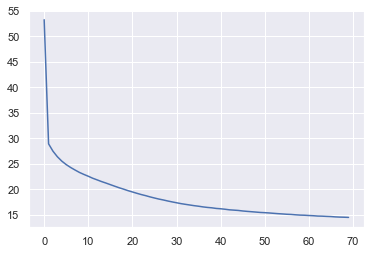

In [35]:
split_data =split_rnn(df,1)
x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_1_1 = Model(inputs=[input1,input2],outputs=[output])
model_1_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss= rmse,
            metrics=[rmse])
history_1_1 = model_1_1.fit([x1_train,x2_train],y_train,epochs=70)
plt.plot(history_1_1.history['loss'])


31
32
x1 (101401, 6)
x2 (101401, 1, 1)
y (101401, 1)
Epoch 1/70
3169/3169 [==============================] - 8s 2ms/step - loss: 169.2593 - rmse: 169.2593
Epoch 2/70
3169/3169 [==============================] - 6s 2ms/step - loss: 29.5673 - rmse: 29.5673: 1s - loss: 29.9335 - ETA: 1s - ETA
Epoch 3/70
3169/3169 [==============================] - 6s 2ms/step - loss: 27.7371 - rmse: 27.7371
Epoch 4/70
3169/3169 [==============================] - 6s 2ms/step - loss: 26.6632 - rmse: 26.6632
Epoch 5/70
3169/3169 [==============================] - 6s 2ms/step - loss: 25.8521 - rmse: 25.8521
Epoch 6/70
3169/3169 [==============================] - 6s 2ms/step - loss: 25.1568 - rmse: 25.1568: 
Epoch 7/70
3169/3169 [==============================] - 6s 2ms/step - loss: 24.6250 - rmse: 24.6250
Epoch 8/70
3169/3169 [==============================] - 6s 2ms/step - loss: 24.1684 - rmse: 24.1684: 0s - loss: 24.2142 - rmse: 24. - ETA: 0s - loss: 2
Epoch 9/70
3169/3169 [==============================] -

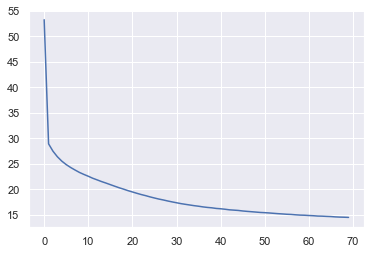

In [36]:
split_data =split_rnn(df,1)
x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_1_2 = Model(inputs=[input1,input2],outputs=[output])
model_1_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss= rmse,
            metrics=[rmse])
history_1_2 = model_1_2.fit([x1_train,x2_train],y_train,epochs=70)
plt.plot(history_1_1.history['loss'])

31
32
x1 (101401, 6)
x2 (101401, 1, 1)
y (101401, 1)
Epoch 1/70
3169/3169 [==============================] - 8s 2ms/step - loss: 34.8353 - rmse: 34.8353
Epoch 2/70
3169/3169 [==============================] - 6s 2ms/step - loss: 29.2202 - rmse: 29.2202: 3s -
Epoch 3/70
3169/3169 [==============================] - 6s 2ms/step - loss: 27.8350 - rmse: 27.8350: 3s - loss: 28.03 - ETA: 2s - l - ETA: 1s - loss: 27.9731 - rmse: - ETA: 0s - loss: 27.9458 - rmse: 27. - ETA: 0s - loss: - ETA: 0s - loss: 27.8227 - rmse: 27.82
Epoch 4/70
3169/3169 [==============================] - 6s 2ms/step - loss: 26.7885 - rmse: 26.7885: 3s - loss: - ETA: 3s - loss: 26. - E
Epoch 5/70
3169/3169 [==============================] - 6s 2ms/step - loss: 25.9170 - rmse: 25.9170: 0s - loss: 26.0205 - r - ETA: 0s - loss: 25.
Epoch 6/70
3169/3169 [==============================] - 6s 2ms/step - loss: 25.2023 - rmse: 25.2023: 4s - loss: 25.2850 - - ETA: 2s - loss: 25.1541 - rmse: - ETA: 1s - l
Epoch 7/70
3169/3169 [===

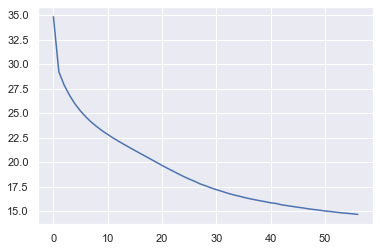

In [37]:
split_data =split_rnn(df,1)
x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_1_3 = Model(inputs=[input1,input2],outputs=[output])
model_1_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss= rmse,
            metrics=[rmse])
history_1_3 = model_1_3.fit([x1_train,x2_train],y_train,epochs=70)
plt.plot(history_1_3.history['loss'])

30
31
x1 (98130, 6)
x2 (98130, 2, 1)
y (98130, 1)
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 2, 1)]       0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 10)           480         input_32[0][0]                   
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 5)            35          input_31[0][0]                   
_________________________________________

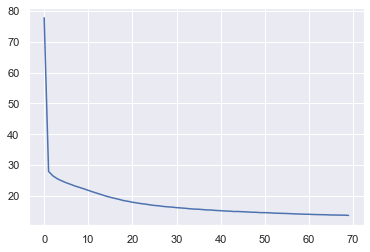

In [38]:
split_data =split_rnn(df,2)
x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_2_1 = Model(inputs=[input1,input2],outputs=[output])

print(model_2_1.summary())  

model_2_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=rmse,
            metrics=[rmse])

history_2_1 = model_2_1.fit([x1_train,x2_train],y_train,epochs=70)

plt.plot(history_2_1.history['loss'])
plt.show()

30
31
x1 (98130, 6)
x2 (98130, 2, 1)
y (98130, 1)
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 2, 1)]       0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_16 (LSTM)                  (None, 10)           480         input_34[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 5)            35          input_33[0][0]                   
_________________________________________

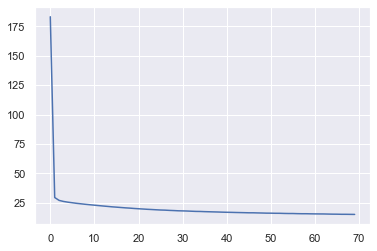

In [39]:
split_data =split_rnn(df,2)
x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_2_2 = Model(inputs=[input1,input2],outputs=[output])

print(model_2_2.summary())  

model_2_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=rmse,
            metrics=[rmse])

history_2_2 = model_2_2.fit([x1_train,x2_train],y_train,epochs=70)

plt.plot(history_2_2.history['loss'])
plt.show()

30
31
x1 (98130, 6)
x2 (98130, 2, 1)
y (98130, 1)
Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 2, 1)]       0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_17 (LSTM)                  (None, 10)           480         input_36[0][0]                   
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 5)            35          input_35[0][0]                   
_________________________________________

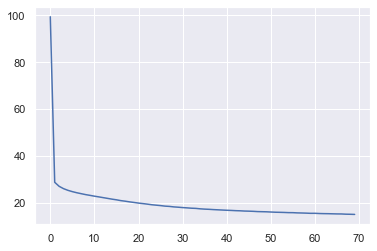

In [40]:
split_data =split_rnn(df,2)
x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_2_3 = Model(inputs=[input1,input2],outputs=[output])

print(model_2_3.summary())  

model_2_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=rmse,
            metrics=[rmse])

history_2_3 = model_2_3.fit([x1_train,x2_train],y_train,epochs=70)

plt.plot(history_2_3.history['loss'])
plt.show()

29
30
x1 (94859, 6)
x2 (94859, 3, 1)
y (94859, 1)
Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_18 (LSTM)                  (None, 10)           480         input_38[0][0]                   
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 5)            35          input_37[0][0]                   
_________________________________________

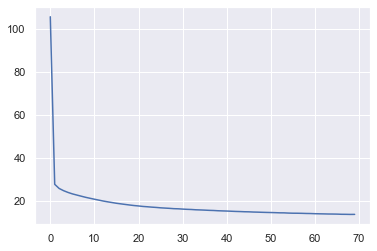

In [41]:
split_data =split_rnn(df,3)
x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_3_1 = Model(inputs=[input1,input2],outputs=[output])

print(model_3_1.summary())  

model_3_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=rmse,
            metrics=[rmse])

history_3_1 = model_3_1.fit([x1_train,x2_train],y_train,epochs=70)

plt.plot(history_3_1.history['loss'])
plt.show()

29
30
x1 (94859, 6)
x2 (94859, 3, 1)
y (94859, 1)
Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_19 (LSTM)                  (None, 10)           480         input_40[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 5)            35          input_39[0][0]                   
_________________________________________

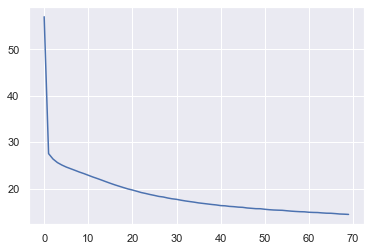

In [42]:
split_data =split_rnn(df,3)
x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_3_2 = Model(inputs=[input1,input2],outputs=[output])

print(model_3_2.summary())  

model_3_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=rmse,
            metrics=[rmse])

history_3_2 = model_3_2.fit([x1_train,x2_train],y_train,epochs=70)

plt.plot(history_3_2.history['loss'])
plt.show()

29
30
x1 (94859, 6)
x2 (94859, 3, 1)
y (94859, 1)
Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_20 (LSTM)                  (None, 10)           480         input_42[0][0]                   
__________________________________________________________________________________________________
dense_60 (Dense)                (None, 5)            35          input_41[0][0]                   
_________________________________________

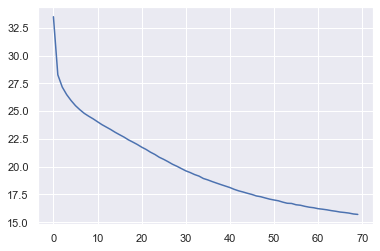

In [43]:
split_data =split_rnn(df,3)
x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_3_3 = Model(inputs=[input1,input2],outputs=[output])

print(model_3_3.summary())  

model_3_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=rmse,
            metrics=[rmse])

history_3_3 = model_3_3.fit([x1_train,x2_train],y_train,epochs=70)

plt.plot(history_3_3.history['loss'])
plt.show()

26
27
x1 (85046, 6)
x2 (85046, 6, 1)
y (85046, 1)
Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 6, 1)]       0                                            
__________________________________________________________________________________________________
input_43 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_21 (LSTM)                  (None, 10)           480         input_44[0][0]                   
__________________________________________________________________________________________________
dense_63 (Dense)                (None, 5)            35          input_43[0][0]                   
_________________________________________

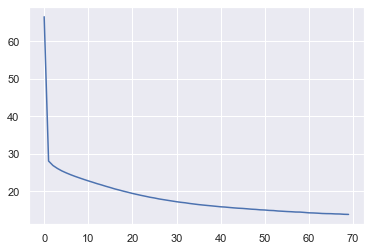

In [44]:
split_data =split_rnn(df,6)
x1_train,x2_train,y_train = split_data['train']

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_6_1 = Model(inputs=[input1,input2],outputs=[output])

print(model_6_1.summary())  

model_6_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=rmse,
            metrics=[rmse])

history_6_1 = model_6_1.fit([x1_train,x2_train],y_train,epochs=70)

plt.plot(history_6_1.history['loss'])
plt.show()

26
27
x1 (85046, 6)
x2 (85046, 6, 1)
y (85046, 1)
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 6, 1)]       0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_22 (LSTM)                  (None, 10)           480         input_46[0][0]                   
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 5)            35          input_45[0][0]                   
_________________________________________

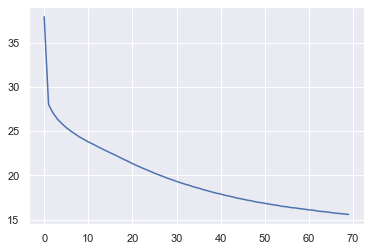

In [45]:
split_data =split_rnn(df,6)
x1_train,x2_train,y_train = split_data['train']

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_6_2 = Model(inputs=[input1,input2],outputs=[output])

print(model_6_2.summary())  

model_6_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=rmse,
            metrics=[rmse])

history_6_2 = model_6_2.fit([x1_train,x2_train],y_train,epochs=70)

plt.plot(history_6_2.history['loss'])
plt.show()

26
27
x1 (85046, 6)
x2 (85046, 6, 1)
y (85046, 1)
Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 6, 1)]       0                                            
__________________________________________________________________________________________________
input_47 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_23 (LSTM)                  (None, 10)           480         input_48[0][0]                   
__________________________________________________________________________________________________
dense_69 (Dense)                (None, 5)            35          input_47[0][0]                   
_________________________________________

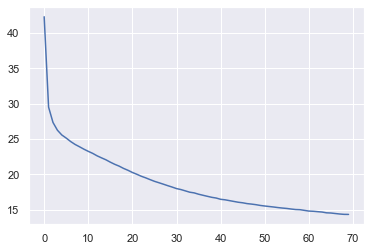

In [46]:
split_data =split_rnn(df,6)
x1_train,x2_train,y_train = split_data['train']

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_6_3 = Model(inputs=[input1,input2],outputs=[output])

print(model_6_3.summary())  

model_6_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=rmse,
            metrics=[rmse])

history_6_3 = model_6_3.fit([x1_train,x2_train],y_train,epochs=70)

plt.plot(history_6_3.history['loss'])
plt.show()

20
21
x1 (65420, 6)
x2 (65420, 12, 1)
y (65420, 1)
Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
input_49 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_24 (LSTM)                  (None, 10)           480         input_50[0][0]                   
__________________________________________________________________________________________________
dense_72 (Dense)                (None, 5)            35          input_49[0][0]                   
________________________________________

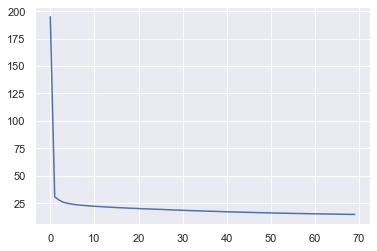

In [47]:
split_data =split_rnn(df,12)
x1_train,x2_train,y_train = split_data['train']

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_12_1 = Model(inputs=[input1,input2],outputs=[output])

print(model_12_1.summary())  

model_12_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=rmse,
            metrics=[rmse])

history_12_1 = model_12_1.fit([x1_train,x2_train],y_train,epochs=70)

plt.plot(history_12_1.history['loss'])
plt.show()

20
21
x1 (65420, 6)
x2 (65420, 12, 1)
y (65420, 1)
Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_25 (LSTM)                  (None, 10)           480         input_52[0][0]                   
__________________________________________________________________________________________________
dense_75 (Dense)                (None, 5)            35          input_51[0][0]                   
________________________________________

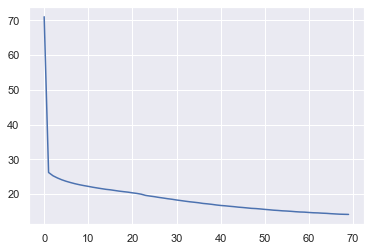

In [48]:
split_data =split_rnn(df,12)
x1_train,x2_train,y_train = split_data['train']

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_12_2 = Model(inputs=[input1,input2],outputs=[output])

print(model_12_2.summary())  

model_12_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=rmse,
            metrics=[rmse])

history_12_2 = model_12_2.fit([x1_train,x2_train],y_train,epochs=70)

plt.plot(history_12_2.history['loss'])
plt.show()

20
21
x1 (65420, 6)
x2 (65420, 12, 1)
y (65420, 1)
Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
input_53 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_26 (LSTM)                  (None, 10)           480         input_54[0][0]                   
__________________________________________________________________________________________________
dense_78 (Dense)                (None, 5)            35          input_53[0][0]                   
________________________________________

Epoch 61/70
2045/2045 [==============================] - 21s 10ms/step - loss: 18.8404 - rmse: 18.8404
Epoch 62/70
2045/2045 [==============================] - 17s 8ms/step - loss: 18.7746 - rmse: 18.7746
Epoch 63/70
2045/2045 [==============================] - 17s 8ms/step - loss: 18.6668 - rmse: 18.6668
Epoch 64/70
2045/2045 [==============================] - 20s 10ms/step - loss: 18.6106 - rmse: 18.6106
Epoch 65/70
2045/2045 [==============================] - 16s 8ms/step - loss: 18.4736 - rmse: 18.4736
Epoch 66/70
2045/2045 [==============================] - 18s 9ms/step - loss: 18.4347 - rmse: 18.4347
Epoch 67/70
2045/2045 [==============================] - 19s 9ms/step - loss: 18.3281 - rmse: 18.3281
Epoch 68/70
2045/2045 [==============================] - 19s 9ms/step - loss: 18.2836 - rmse: 18.2836 0s - loss: 18.2615 - rmse: 18. - ETA: 
Epoch 69/70
2045/2045 [==============================] - 18s 9ms/step - loss: 18.1537 - rmse: 18.1537
Epoch 70/70
2045/2045 [==================

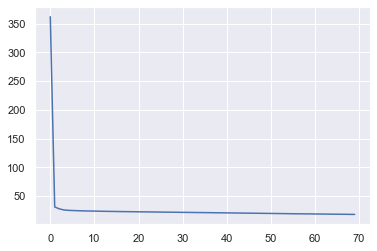

In [49]:
split_data =split_rnn(df,12)
x1_train,x2_train,y_train = split_data['train']

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1 = LSTM(10)(input2)
layer2 = Dense(5)(input1) 
layer3 = Concatenate()([layer1,layer2])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model_12_3 = Model(inputs=[input1,input2],outputs=[output])

print(model_12_3.summary())  

model_12_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=rmse,
            metrics=[rmse])

history_12_3 = model_12_3.fit([x1_train,x2_train],y_train,epochs=70)

plt.plot(history_12_3.history['loss'])
plt.show()

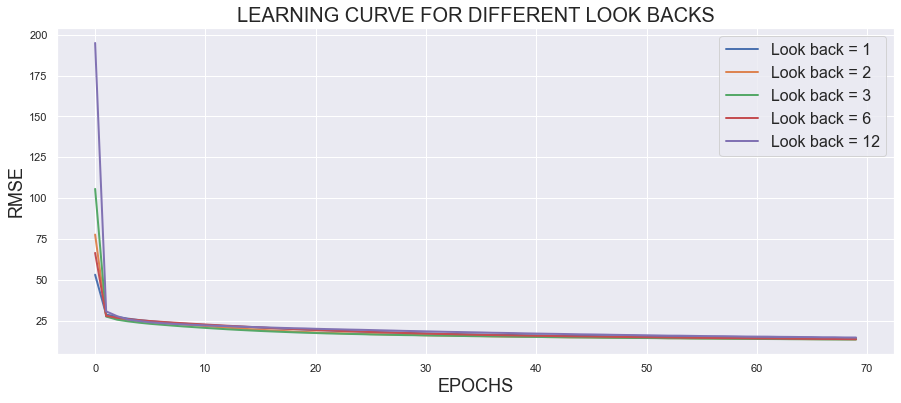

In [61]:
sns.set()
plt.figure(figsize=(15,6))
plt.plot(history_1_1.history['loss'], label='Look back = 1',linewidth=2)
plt.plot(history_2_1.history['loss'],label='Look back = 2',linewidth=2)
plt.plot(history_3_1.history['loss'],label='Look back = 3',linewidth=2)
plt.plot(history_6_1.history['loss'],label='Look back = 6',linewidth=2)
plt.plot(history_12_1.history['loss'],label='Look back = 12',linewidth=2)
plt.xlabel('EPOCHS',fontsize=18)
plt.ylabel('RMSE',fontsize=18)
plt.title('LEARNING CURVE FOR DIFFERENT LOOK BACKS',fontsize=20)
plt.legend(fontsize=16)
plt.show()

In [51]:
split_data = split_rnn(df,1)
x1_test,x2_test,y_test = split_data['test']
y_pred_test = model_1_1.predict([x1_test,x2_test])
op1_1,man1_1 = eval (x1_test,y_test,y_pred_test)

y_pred_test = model_1_2.predict([x1_test,x2_test])
op1_2,man1_2 = eval (x1_test,y_test,y_pred_test)

y_pred_test = model_1_3.predict([x1_test,x2_test])
op1_3,man1_3 = eval (x1_test,y_test,y_pred_test)

op1 = (op1_1+op1_2+op1_3)/3
man1 = (man1_1+man1_2+man1_3)/3

######33
split_data = split_rnn(df,2)
x1_test,x2_test,y_test = split_data['test']
y_pred_test = model_2_1.predict([x1_test,x2_test])
op2_1,man2_1 = eval (x1_test,y_test,y_pred_test)

y_pred_test = model_2_2.predict([x1_test,x2_test])
op2_2,man2_2 = eval (x1_test,y_test,y_pred_test)

y_pred_test = model_2_3.predict([x1_test,x2_test])
op2_3,man2_3 = eval (x1_test,y_test,y_pred_test)

op2 = (op2_1+op2_2+op2_3)/3
man2 = (man2_1+man2_2+man2_3)/3
########33
split_data = split_rnn(df,3)
x1_test,x2_test,y_test = split_data['test']
y_pred_test = model_3_1.predict([x1_test,x2_test])
op3_1,man3_1 = eval (x1_test,y_test,y_pred_test)

y_pred_test = model_3_2.predict([x1_test,x2_test])
op3_2,man3_2 = eval (x1_test,y_test,y_pred_test)

y_pred_test = model_3_3.predict([x1_test,x2_test])
op3_3,man3_3 = eval (x1_test,y_test,y_pred_test)

op3 = (op3_1+op3_2+op3_3)/3
man3 = (man3_1+man3_2+man3_3)/3

########33
split_data = split_rnn(df,6)
x1_test,x2_test,y_test = split_data['test']
y_pred_test = model_6_1.predict([x1_test,x2_test])
op6_1,man6_1 = eval (x1_test,y_test,y_pred_test)

y_pred_test = model_6_2.predict([x1_test,x2_test])
op6_2,man6_2 = eval (x1_test,y_test,y_pred_test)

y_pred_test = model_6_3.predict([x1_test,x2_test])
op6_3,man6_3 = eval (x1_test,y_test,y_pred_test)

op6 = (op6_1+op6_2+op6_3)/3
man6 = (man6_1+man6_2+man6_3)/3

########33
split_data = split_rnn(df,12)
x1_test,x2_test,y_test = split_data['test']
y_pred_test = model_12_1.predict([x1_test,x2_test])
op12_1,man12_1 = eval (x1_test,y_test,y_pred_test)

y_pred_test = model_12_2.predict([x1_test,x2_test])
op12_2,man12_2 = eval (x1_test,y_test,y_pred_test)

y_pred_test = model_12_3.predict([x1_test,x2_test])
op12_3,man12_3 = eval (x1_test,y_test,y_pred_test)

op12 = (op12_1+op12_2+op12_3)/3
man12 = (man12_1+man12_2+man12_3)/3

31
32
Costo de oportunidad:  945.0321417981996
Costo de mantenimiento:  75.95297505971703
Costo de oportunidad:  2168.1450202292676
Costo de mantenimiento:  74.66748612844536
Costo de oportunidad:  0.0
Costo de mantenimiento:  nan
30
31
Costo de oportunidad:  719.5670804051276
Costo de mantenimiento:  72.11063085430894
Costo de oportunidad:  680.0510795107518
Costo de mantenimiento:  74.85534117163634
Costo de oportunidad:  1481.3032856098066
Costo de mantenimiento:  77.02522635962639
29
30
Costo de oportunidad:  670.2676366012747
Costo de mantenimiento:  73.3331251760495
Costo de oportunidad:  1273.9801383651532
Costo de mantenimiento:  76.43723282560438
Costo de oportunidad:  1924.45504384238
Costo de mantenimiento:  72.89595691641783
26
27
Costo de oportunidad:  1197.5369785399166
Costo de mantenimiento:  76.82098699351008
Costo de oportunidad:  888.4327451018306
Costo de mantenimiento:  73.5140157826844
Costo de oportunidad:  1469.89834624345
Costo de mantenimiento:  75.56994188074

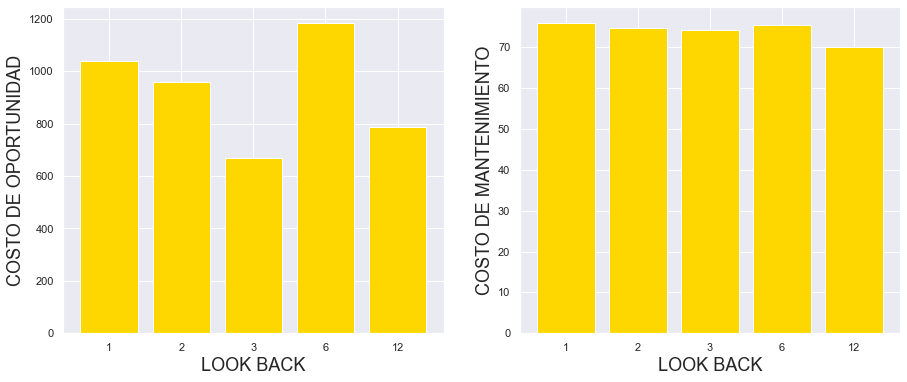

In [59]:
op = [op1,op2,op3_1,op6,op12]
man = [man1_1,man2,man3,man6,man12]
x = ['1','2','3','6','12']
plt.figure(figsize = (15,6))
plt.subplot(121)
plt.bar(x,op,color='gold')
plt.xlabel('LOOK BACK',fontsize=18)
plt.ylabel('COSTO DE OPORTUNIDAD',fontsize=18)
plt.subplot(122)
plt.bar(x,man,color='gold')
plt.xlabel('LOOK BACK',fontsize=18)
plt.ylabel('COSTO DE MANTENIMIENTO',fontsize=18)
plt.show()


## **GRID SEARCH RED RECURRENTE**

In [13]:
def create_model(neurons1,neurons2,activation,x1_train,x2_train,learning_rate=1e-4):

    input1 = Input(shape=x1_train.shape[1])
    input2 = Input(shape=x2_train.shape[1:])

    layer1_rnn = LSTM(neurons1,return_sequences=True,activation = activation)(input2)
    layer2_rnn = LSTM(neurons2,return_sequences=True,activation = activation)(layer1_rnn)
    layer2_rnn = LSTM(10,activation = activation)(layer2_rnn)
    layer1_dense = Dense(15)(input1) 
    layer3 = Concatenate()([layer2_rnn,layer1_dense])
    layer3 = Dense(10)(layer3)
    output = Dense(1)(layer3)
    model = Model(inputs=[input1,input2],outputs=[output])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=rmse,
                metrics=[rmse])
    
    return model

In [15]:
mymodel = create_model(20,15,'relu',x1_train,x2_train)
history= mymodel.fit([x1_train,x2_train],y_train,epochs=2)

Epoch 1/2
2045/2045 [==============================] - 21s 8ms/step - loss: 266.9997 - rmse: 266.9997
Epoch 2/2
2045/2045 [==============================] - 18s 9ms/step - loss: 15.5812 - rmse: 15.5812


In [33]:
def GridSearch_(fn_estimator,param_grid,x1_train,x2_train,y_train,epochs):
    error = {}
    for activation in param_grid['activation']:
        for neurons1 in param_grid['neurons1']:
            for neurons2 in param_grid['neurons2']:
                model = fn_estimator(neurons1 = neurons1,
                                  neurons2 = neurons2,
                                  activation = activation,
                                  x1_train = x1_train,
                                  x2_train = x2_train)

                print('Model')
                print('________________________________________________________________-')
                history= model.fit([x1_train,x2_train],y_train,epochs=epochs)
                error['neurons1: '+str(neurons1)+
                      ' neurons2: '+str(neurons2)+
                      ' activtion: '+str(activation)] = history.history['loss'][-1]
                
    return error

In [34]:
split_data =split_rnn(df,3)
x1_train,x2_train,y_train = split_data['train']
parameters = {'activation':['relu','tanh'],
              'neurons1': [20,50,100],
              'neurons2':[25,30]}
gridSearch = GridSearch_(fn_estimator = create_model,
                         param_grid = parameters,
                         x1_train=x1_train,
                         x2_train=x2_train,
                         y_train=y_train,
                         epochs=10)

29
30
Model
________________________________________________________________-
Epoch 1/10
2965/2965 [==============================] - 14s 4ms/step - loss: 35.9993 - rmse: 35.9993
Epoch 2/10
2965/2965 [==============================] - 11s 4ms/step - loss: 10.6001 - rmse: 10.6001
Epoch 3/10
2965/2965 [==============================] - 11s 4ms/step - loss: 10.4250 - rmse: 10.4250
Epoch 4/10
2965/2965 [==============================] - 11s 4ms/step - loss: 10.3681 - rmse: 10.3681
Epoch 5/10
2965/2965 [==============================] - 15s 5ms/step - loss: 10.2758 - rmse: 10.2758
Epoch 6/10
2965/2965 [==============================] - 23s 8ms/step - loss: 10.2217 - rmse: 10.2217
Epoch 7/10
2965/2965 [==============================] - 24s 8ms/step - loss: 10.2266 - rmse: 10.2266
Epoch 8/10
2965/2965 [==============================] - 23s 8ms/step - loss: 10.2493 - rmse: 10.2493
Epoch 9/10
2965/2965 [==============================] - 24s 8ms/step - loss: 10.3492 - rmse: 10.3492
Epoch 10/10
2

2965/2965 [==============================] - 31s 11ms/step - loss: 23.3627 - rmse: 23.3627
Epoch 6/10
2965/2965 [==============================] - 31s 11ms/step - loss: 22.7663 - rmse: 22.7663
Epoch 7/10
2965/2965 [==============================] - 31s 11ms/step - loss: 22.1892 - rmse: 22.1892
Epoch 8/10
2965/2965 [==============================] - 32s 11ms/step - loss: 21.7000 - rmse: 21.7000
Epoch 9/10
2965/2965 [==============================] - 31s 11ms/step - loss: 21.2464 - rmse: 21.2464
Epoch 10/10
2965/2965 [==============================] - 31s 10ms/step - loss: 20.7162 - rmse: 20.7162
Model
________________________________________________________________-
Epoch 1/10
2965/2965 [==============================] - 45s 11ms/step - loss: 42.7671 - rmse: 42.7671
Epoch 2/10
2965/2965 [==============================] - 32s 11ms/step - loss: 25.8699 - rmse: 25.8699
Epoch 3/10
2965/2965 [==============================] - 33s 11ms/step - loss: 24.3614 - rmse: 24.3614
Epoch 4/10
2965/2965

In [37]:
gridSearch

{'neurons1: 20 neurons2: 25 activtion: relu': 10.290250778198242,
 'neurons1: 20 neurons2: 30 activtion: relu': 10.256019592285156,
 'neurons1: 50 neurons2: 25 activtion: relu': 10.156088829040527,
 'neurons1: 50 neurons2: 30 activtion: relu': 10.100090026855469,
 'neurons1: 100 neurons2: 25 activtion: relu': 10.218920707702637,
 'neurons1: 100 neurons2: 30 activtion: relu': 10.178378105163574,
 'neurons1: 20 neurons2: 25 activtion: tanh': 21.522138595581055,
 'neurons1: 20 neurons2: 30 activtion: tanh': 20.716211318969727,
 'neurons1: 50 neurons2: 25 activtion: tanh': 19.608749389648438,
 'neurons1: 50 neurons2: 30 activtion: tanh': 20.5978946685791,
 'neurons1: 100 neurons2: 25 activtion: tanh': 21.394603729248047,
 'neurons1: 100 neurons2: 30 activtion: tanh': 21.08484649658203}

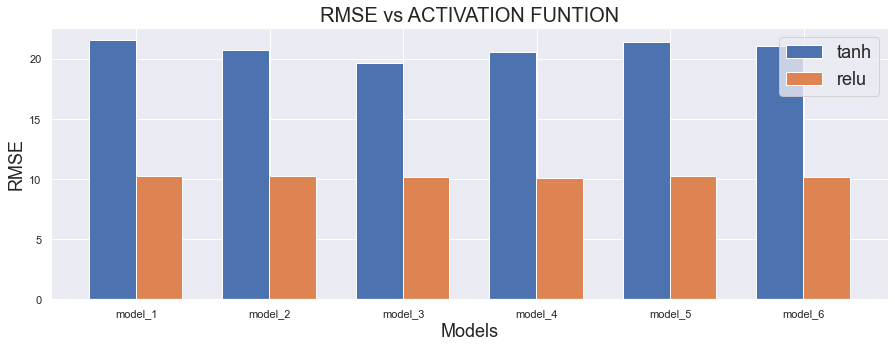

In [75]:
sns.set()
score_relu = list(gridSearch.values())[:6]
score_tanh = list(gridSearch.values())[6:]
x_label = ['model_1','model_2','model_3','model_4','model_5','model_6']
x = np.arange(6)
plt.figure(figsize=(15,5))
plt.bar(x,score_tanh,label='tanh',width=0.35)
plt.bar(x+0.35,score_relu,label='relu',width=0.35)
plt.xticks(x+0.18 , x_label)
plt.xlabel('Models',fontsize=18)
plt.ylabel('RMSE',fontsize=18)
plt.title('RMSE vs ACTIVATION FUNTION',fontsize=20)
plt.legend(fontsize=18)
plt.show()